In [1]:
# -----------------------------
# 1. Imports and Setup
# -----------------------------
import os
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold  # Changed import
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import gc
from torch.cuda.amp import GradScaler, autocast  # Corrected import for mixed precision
import seaborn as sns
import shap  # For SHAP explanations
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Optional: Clear CPU memory cache
gc.collect()

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Initialize GradScaler for mixed precision
scaler_amp = GradScaler()

In [2]:
# -----------------------------
# 2. Data Loading and Preprocessing
# -----------------------------

# Set the device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the data
# Replace the file path with your actual data path
tns_file = "C:/Users/ivatu/Downloads/FRB/tns_public_objects.xlsx"  
tns_data = pd.read_excel(tns_file)
print("\nData loaded successfully. First few rows:")
print(tns_data.head())

# Ensure required columns are present
required_columns = ['ra', 'declination', 'discoverydate', 'discoverymag', 'redshift']
missing_columns = [col for col in required_columns if col not in tns_data.columns]
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")
print("\nAll required columns are present.")

# Convert 'discoverydate' to datetime and handle missing values
tns_data['discoverydate'] = pd.to_datetime(tns_data['discoverydate'], errors='coerce')
for col in ['ra', 'declination', 'discoverymag', 'redshift']:
    tns_data[col] = pd.to_numeric(tns_data[col], errors='coerce')

# Drop rows with missing values in critical columns
initial_shape = tns_data.shape
tns_data.dropna(subset=['ra', 'declination', 'discoverydate'], inplace=True)
print(f"\nDropped {initial_shape[0] - tns_data.shape[0]} rows with missing critical values.")

# -----------------------------
# 3. Feature Engineering
# -----------------------------

# Feature Engineering: Extract year, month, day, hour from 'discoverydate'
tns_data['year'] = tns_data['discoverydate'].dt.year
tns_data['month'] = tns_data['discoverydate'].dt.month
tns_data['day'] = tns_data['discoverydate'].dt.day
tns_data['hour'] = tns_data['discoverydate'].dt.hour
tns_data.drop(columns=['discoverydate'], inplace=True)

# Select only numeric columns
numeric_columns = ['ra', 'declination', 'discoverymag', 'redshift', 'year', 'month', 'day', 'hour']
tns_data = tns_data[numeric_columns]
print("\nSelected numeric columns.")

# Handle missing values by imputation (already dropped critical NAs)
imputer = SimpleImputer(strategy='mean')
tns_data = pd.DataFrame(imputer.fit_transform(tns_data), columns=tns_data.columns)
print("\nApplied mean imputation to handle remaining missing values.")

# Define features (X) and targets (y)
# Features: 'discoverymag', 'redshift'
# Targets: 'ra', 'declination', 'year', 'month', 'day', 'hour'
X = tns_data[['discoverymag', 'redshift']]
y = tns_data[['ra', 'declination', 'year', 'month', 'day', 'hour']]

# Feature Scaling and Dimensionality Reduction for X
# Adjust PCA to retain sufficient components (e.g., 5 components)
pca_components = 5  # Adjust based on desired feature dimensionality
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(n_components=pca_components, random_state=SEED))
])
X_transformed = pipeline.fit_transform(X)
print(f"\nApplied StandardScaler, PolynomialFeatures, and PCA to X. Reduced to {X_transformed.shape[1]} components.")

# Combine X and y for duplicate handling
X_y_combined = np.hstack((X_transformed, y.values))
# Define column names based on PCA components and original targets
feature_columns = [f'feature{i+1}' for i in range(X_transformed.shape[1])]
columns = feature_columns + ['ra', 'declination', 'year', 'month', 'day', 'hour']
df_combined = pd.DataFrame(X_y_combined, columns=columns)

# Round features to reduce floating-point precision issues
for col in feature_columns:
    df_combined[col] = df_combined[col].round(6)  # Increased precision

# Remove duplicate feature entries by averaging targets
df_unique = df_combined.groupby(feature_columns).mean().reset_index()

# Further ensure no duplicates by using stricter rounding
for col in feature_columns:
    df_unique[col] = df_unique[col].round(6)  # Increase decimal precision if necessary

# Remove duplicates again after stricter rounding
df_unique = df_unique.groupby(feature_columns).mean().reset_index()

# Verify duplicates
duplicates_final = pd.DataFrame(df_unique[feature_columns]).duplicated().sum()
print(f"Duplicates in X after stricter removal: {duplicates_final}")

# Remove near-duplicates using VarianceThreshold
selector = VarianceThreshold(threshold=1e-5)
X_transformed_unique = selector.fit_transform(df_unique[feature_columns].values)

# Update feature_columns accordingly
feature_columns = [f'feature{i+1}' for i in range(X_transformed_unique.shape[1])]

# Extract unique X and y
y_values_unique = df_unique[['ra', 'declination', 'year', 'month', 'day', 'hour']].values
print(f"\nShape of X after removing duplicates: {X_transformed_unique.shape}")
print(f"Shape of y after removing duplicates: {y_values_unique.shape}")

# Final check for duplicates in X_transformed_unique
duplicates_final = pd.DataFrame(X_transformed_unique).duplicated().sum()
print(f"Duplicates in X after removing duplicates in X and y: {duplicates_final}")

# Normalize the features
feature_scaler = StandardScaler()
X_transformed_unique = feature_scaler.fit_transform(X_transformed_unique)

# Interaction Terms: RA × Year and DEC × Year
# This can help the model capture interactions between spatial and temporal features
ra = y_values_unique[:, 0]
dec = y_values_unique[:, 1]
year = y_values_unique[:, 2]
interaction_ra_year = ra * year
interaction_dec_year = dec * year

# Append interaction terms to y
y_df = pd.DataFrame(y_values_unique, columns=['ra', 'declination', 'year', 'month', 'day', 'hour'])
y_df['ra_year'] = interaction_ra_year
y_df['dec_year'] = interaction_dec_year

# Feature Scaling for interaction terms
interaction_scaler = StandardScaler()
y_df[['ra_year', 'dec_year']] = interaction_scaler.fit_transform(y_df[['ra_year', 'dec_year']])

# Define the new target columns including interaction terms
target_columns = ['ra', 'declination', 'year', 'month', 'day', 'hour', 'ra_year', 'dec_year']

# Handle periodic features: RA and DEC
# Convert RA and DEC to sine and cosine components to handle angular periodicity
y_df['ra_rad'] = np.radians(y_df['ra'])
y_df['dec_rad'] = np.radians(y_df['declination'])

# Create sine and cosine components
y_df['ra_sin'] = np.sin(y_df['ra_rad'])
y_df['ra_cos'] = np.cos(y_df['ra_rad'])
y_df['dec_sin'] = np.sin(y_df['dec_rad'])
y_df['dec_cos'] = np.cos(y_df['dec_rad'])

# Drop original RA and DEC
y_df.drop(columns=['ra', 'declination', 'ra_rad', 'dec_rad'], inplace=True)

# Define final target columns
final_target_columns = ['ra_sin', 'ra_cos', 'dec_sin', 'dec_cos', 'year', 'month', 'day', 'hour', 'ra_year', 'dec_year']
y_transformed = y_df[final_target_columns].values

# Normalize the targets to stabilize training
target_scaler = StandardScaler()
y_values_unique_scaled = target_scaler.fit_transform(y_transformed)

# Convert data to PyTorch tensors (float32 for consistency)
X_tensor = torch.tensor(X_transformed_unique, dtype=torch.float32)
y_tensor = torch.tensor(y_values_unique_scaled, dtype=torch.float32)



Using device: cuda

Data loaded successfully. First few rows:
    objid name_prefix      name          ra  declination  redshift  typeid  \
0  165592          AT   2024zzz   55.609583     9.205381  0.000000    27.0   
1  165272          AT   2024znz  114.428954    51.070374       NaN     NaN   
2  164688          AT   2024yrr   30.642304    23.640208  0.042413     NaN   
3  165890          AT  2024aalh  295.194250    39.477083       NaN     NaN   
4  165889          AT  2024aalg  319.476324    22.851585       NaN     NaN   

  type  reporting_groupid reporting_group  ...  discoverymag discmagfilter  \
0   CV               48.0             ZTF  ...       18.0656         110.0   
1  NaN               48.0             ZTF  ...       20.1691         111.0   
2  NaN               60.0        BlackGEM  ...       17.8100         118.0   
3  NaN               10.0            XOSS  ...       18.7300           1.0   
4  NaN               74.0          ALeRCE  ...       19.7446         111.0   



In [ ]:
# Normalize the features
feature_scaler = StandardScaler()
X_transformed_unique = feature_scaler.fit_transform(X_transformed_unique)

# Normalize the targets to stabilize training
target_scaler = StandardScaler()
y_values_unique_scaled = target_scaler.fit_transform(y_values_unique)

# Convert data to PyTorch tensors (float32 for consistency)
X_tensor = torch.tensor(X_transformed_unique, dtype=torch.float32)
y_tensor = torch.tensor(y_values_unique_scaled, dtype=torch.float32)


In [3]:
# -----------------------------
# 4. Neural Network Definition
# -----------------------------

import torch.nn as nn

class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, 1)
        )
    
    def forward(self, x):
        weights = self.attention(x)
        weights = torch.softmax(weights, dim=1)
        attended = torch.sum(weights * x, dim=1, keepdim=True)
        return attended

class MultiTaskNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MultiTaskNN, self).__init__()
        # Shared layers
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        self.shared_network = nn.Sequential(*layers)
        
        # Attention Mechanism
        self.attention = AttentionLayer(prev_dim)
        
        # Task-specific subnetworks
        # Spatial tasks: ra_sin, ra_cos, dec_sin, dec_cos
        self.spatial_network = nn.Sequential(
            nn.Linear(prev_dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )
        
        # Temporal tasks: year, month, day, hour, ra_year, dec_year
        self.temporal_network = nn.Sequential(
            nn.Linear(prev_dim + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )
        
    def forward(self, x):
        shared_out = self.shared_network(x)
        attended = self.attention(shared_out)
        combined = torch.cat([shared_out, attended], dim=1)
        spatial_out = self.spatial_network(combined)
        temporal_out = self.temporal_network(combined)
        return torch.cat([spatial_out, temporal_out], dim=1)

# Initialize the model
input_dim = X_tensor.shape[1]  # Number of features after PCA and scaling
hidden_dims = [256, 128, 64]  # Increased hidden layer sizes for better capacity
output_dim = 10  # Number of targets: ra_sin, ra_cos, dec_sin, dec_cos, year, month, day, hour, ra_year, dec_year

model = MultiTaskNN(input_dim, hidden_dims, output_dim).to(device)
print("\nNeural Network model initialized.")

# -----------------------------
# 5. Custom Loss Functions
# -----------------------------

class CustomWeightedMSELoss(nn.Module):
    def __init__(self, weights):
        """
        Initializes the CustomWeightedMSELoss.

        Args:
            weights (torch.Tensor): A 1D tensor containing weights for each output feature.
        """
        super(CustomWeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, preds, targets):
        """
        Forward pass for the loss computation.

        Args:
            preds (torch.Tensor): Predictions from the model. Shape: [batch_size, output_dim]
            targets (torch.Tensor): Ground truth targets. Shape: [batch_size, output_dim]

        Returns:
            torch.Tensor: The computed weighted MSE loss.
        """
        # Compute element-wise MSE loss without reduction
        loss = (preds - targets) ** 2  # Shape: [batch_size, output_dim]
        
        # Apply the weights to each output feature
        weighted_loss = loss * self.weights  # Broadcasting weights across the batch
        
        # Return the mean loss over the batch and features
        return weighted_loss.mean()

# Define weights: [2.0]*4 for RA and DEC components, [1.0]*6 for other targets
loss_weights = torch.tensor([2.0]*4 + [1.0]*6).to(device)  # Shape: [10]

# Initialize the custom loss function with the defined weights
criterion = CustomWeightedMSELoss(weights=loss_weights)



Neural Network model initialized.


In [4]:
# -----------------------------
# 6. Training Loop with Enhancements
# -----------------------------

print("\nTraining Multi-Task Neural Network on GPU...")
start_time = time.time()
rmse_scores_nn = []

# Cross-validation setup using KFold suitable for regression
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)  # Using KFold for regression

# Hyperparameters
num_epochs = 100
batch_size = 512  # Increased batch size for better GPU utilization
learning_rate = 0.001
patience = 10  # For Early Stopping

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):  # Using KFold without stratification
    print(f"\nStarting Fold {fold+1}/5")
    
    # Split data
    X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
    y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]
    
    # Data Augmentation: Random rotation for angular features (RA and DEC)
    class AngularDataset(torch.utils.data.Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y
        
        def __len__(self):
            return len(self.X)
        
        def __getitem__(self, idx):
            try:
                x = self.X[idx]
                y = self.y[idx]
                # Apply random rotation to RA and DEC components
                angle = np.random.uniform(-np.pi/12, np.pi/12)  # Rotate by ±15 degrees
                ra_sin, ra_cos = y[0].item(), y[1].item()
                dec_sin, dec_cos = y[2].item(), y[3].item()
                
                # Rotate RA
                ra_sin_new = ra_sin * np.cos(angle) - ra_cos * np.sin(angle)
                ra_cos_new = ra_sin * np.sin(angle) + ra_cos * np.cos(angle)
                
                # Rotate DEC
                dec_sin_new = dec_sin * np.cos(angle) - dec_cos * np.sin(angle)
                dec_cos_new = dec_sin * np.sin(angle) + dec_cos * np.cos(angle)
                
                # Clone y to avoid modifying the original tensor
                y_aug = y.clone()
                y_aug[0] = torch.tensor(ra_sin_new, dtype=torch.float32)
                y_aug[1] = torch.tensor(ra_cos_new, dtype=torch.float32)
                y_aug[2] = torch.tensor(dec_sin_new, dtype=torch.float32)
                y_aug[3] = torch.tensor(dec_cos_new, dtype=torch.float32)
                
                return x, y_aug
            except Exception as e:
                print(f"Error in __getitem__ at index {idx}: {e}")
                raise e  # Re-raise to propagate the error
    
    # Initialize datasets
    train_dataset = AngularDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    # Initialize DataLoaders with num_workers=0 for debugging
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Set to 0 for debugging
        pin_memory=True  # Optional: Keep it as per your setup
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # Set to 0 for debugging
        pin_memory=True  # Optional: Keep it as per your setup
    )
    
    # Initialize the model for each fold
    model = MultiTaskNN(input_dim, hidden_dims, output_dim).to(device)
    
    # Check and utilize multiple GPUs
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight_decay for regularization
    
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Initialize GradScaler for mixed precision
    scaler_train = GradScaler()
    
    best_val_rmse = float('inf')
    trigger_times = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            # Mixed Precision Training
            with autocast():
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)  # Loss is already weighted
            
            # Backward pass and optimization
            scaler_train.scale(loss).backward()
            # Gradient Clipping
            scaler_train.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # Optimizer step
            scaler_train.step(optimizer)
            # Updates the scale for next iteration
            scaler_train.update()
            
            running_loss += loss.item() * X_batch.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_actuals = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device, non_blocking=True)
                y_batch = y_batch.to(device, non_blocking=True)
                with autocast():
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)  # Loss is already weighted
                val_loss += loss.item() * X_batch.size(0)
                all_preds.append(outputs.cpu().numpy())
                all_actuals.append(y_batch.cpu().numpy())
        
        val_loss /= len(val_loader.dataset)
        val_rmse = np.sqrt(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val RMSE: {val_rmse:.4f}")
        
        # Step the scheduler
        scheduler.step(val_loss)
        
        # Early Stopping
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(model.state_dict(), f'best_model_fold{fold+1}.pth')
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered!")
                break
    
    # Load the best model
    model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth', map_location=device))
    
    # Predictions on validation set
    preds = []
    actuals = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    
    preds = np.vstack(preds)
    actuals = np.vstack(actuals)
    
    # Inverse transform the targets for RMSE and R2 calculation
    preds_inversed = target_scaler.inverse_transform(preds)
    actuals_inversed = target_scaler.inverse_transform(actuals)
    
    # Compute RMSE for each target variable
    rmse = np.sqrt(np.mean((preds_inversed - actuals_inversed) ** 2, axis=0))
    rmse_scores_nn.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse}")
    
    # Calculate R² for each target
    r2 = r2_score(actuals_inversed, preds_inversed, multioutput='raw_values')
    print(f"Fold {fold+1} R²: {r2}")
    
    # Generate Residual Plots for each target
    residuals = actuals_inversed - preds_inversed
    for i, col in enumerate(final_target_columns):
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=actuals_inversed[:, i], y=residuals[:, i], alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f'Residual Plot for {col}')
        plt.xlabel(f'Actual {col}')
        plt.ylabel('Residuals')
        plt.tight_layout()
        plt.savefig(f'residual_plot_fold{fold+1}_{col}.png')
        plt.close()
    
    # Clear GPU cache to free up memory
    torch.cuda.empty_cache()

end_time = time.time()

# Convert list of RMSE arrays to a NumPy array for easier computation
rmse_scores_nn = np.array(rmse_scores_nn)

# Compute mean and standard deviation RMSE for each target across folds
mean_rmse_per_target = np.mean(rmse_scores_nn, axis=0)
std_rmse_per_target = np.std(rmse_scores_nn, axis=0)

# Compute overall mean RMSE
overall_mean_rmse = np.mean(mean_rmse_per_target)

print(f"\nTraining completed successfully in {end_time - start_time:.2f} seconds.")
print(f"\nMean RMSE per target on validation sets (Multi-Task NN):")
for idx, col in enumerate(final_target_columns):
    print(f"{col}: {mean_rmse_per_target[idx]:.4f} ± {std_rmse_per_target[idx]:.4f}")
print(f"\nOverall Mean RMSE: {overall_mean_rmse:.4f}")


Training Multi-Task Neural Network on GPU...

Starting Fold 1/5
Epoch 1/100 - Train Loss: 1.3768 - Val RMSE: 1.1637
Epoch 2/100 - Train Loss: 1.3467 - Val RMSE: 1.1604
Epoch 3/100 - Train Loss: 1.3406 - Val RMSE: 1.1587
Epoch 4/100 - Train Loss: 1.3379 - Val RMSE: 1.1575
Epoch 5/100 - Train Loss: 1.3372 - Val RMSE: 1.1568
Epoch 6/100 - Train Loss: 1.3363 - Val RMSE: 1.1571
Epoch 7/100 - Train Loss: 1.3365 - Val RMSE: 1.1561
Epoch 8/100 - Train Loss: 1.3349 - Val RMSE: 1.1571
Epoch 9/100 - Train Loss: 1.3340 - Val RMSE: 1.1564
Epoch 10/100 - Train Loss: 1.3325 - Val RMSE: 1.1559
Epoch 11/100 - Train Loss: 1.3320 - Val RMSE: 1.1554
Epoch 12/100 - Train Loss: 1.3323 - Val RMSE: 1.1547
Epoch 13/100 - Train Loss: 1.3313 - Val RMSE: 1.1557
Epoch 14/100 - Train Loss: 1.3307 - Val RMSE: 1.1548
Epoch 15/100 - Train Loss: 1.3307 - Val RMSE: 1.1544
Epoch 16/100 - Train Loss: 1.3304 - Val RMSE: 1.1550
Epoch 17/100 - Train Loss: 1.3303 - Val RMSE: 1.1547
Epoch 18/100 - Train Loss: 1.3291 - Val RMS

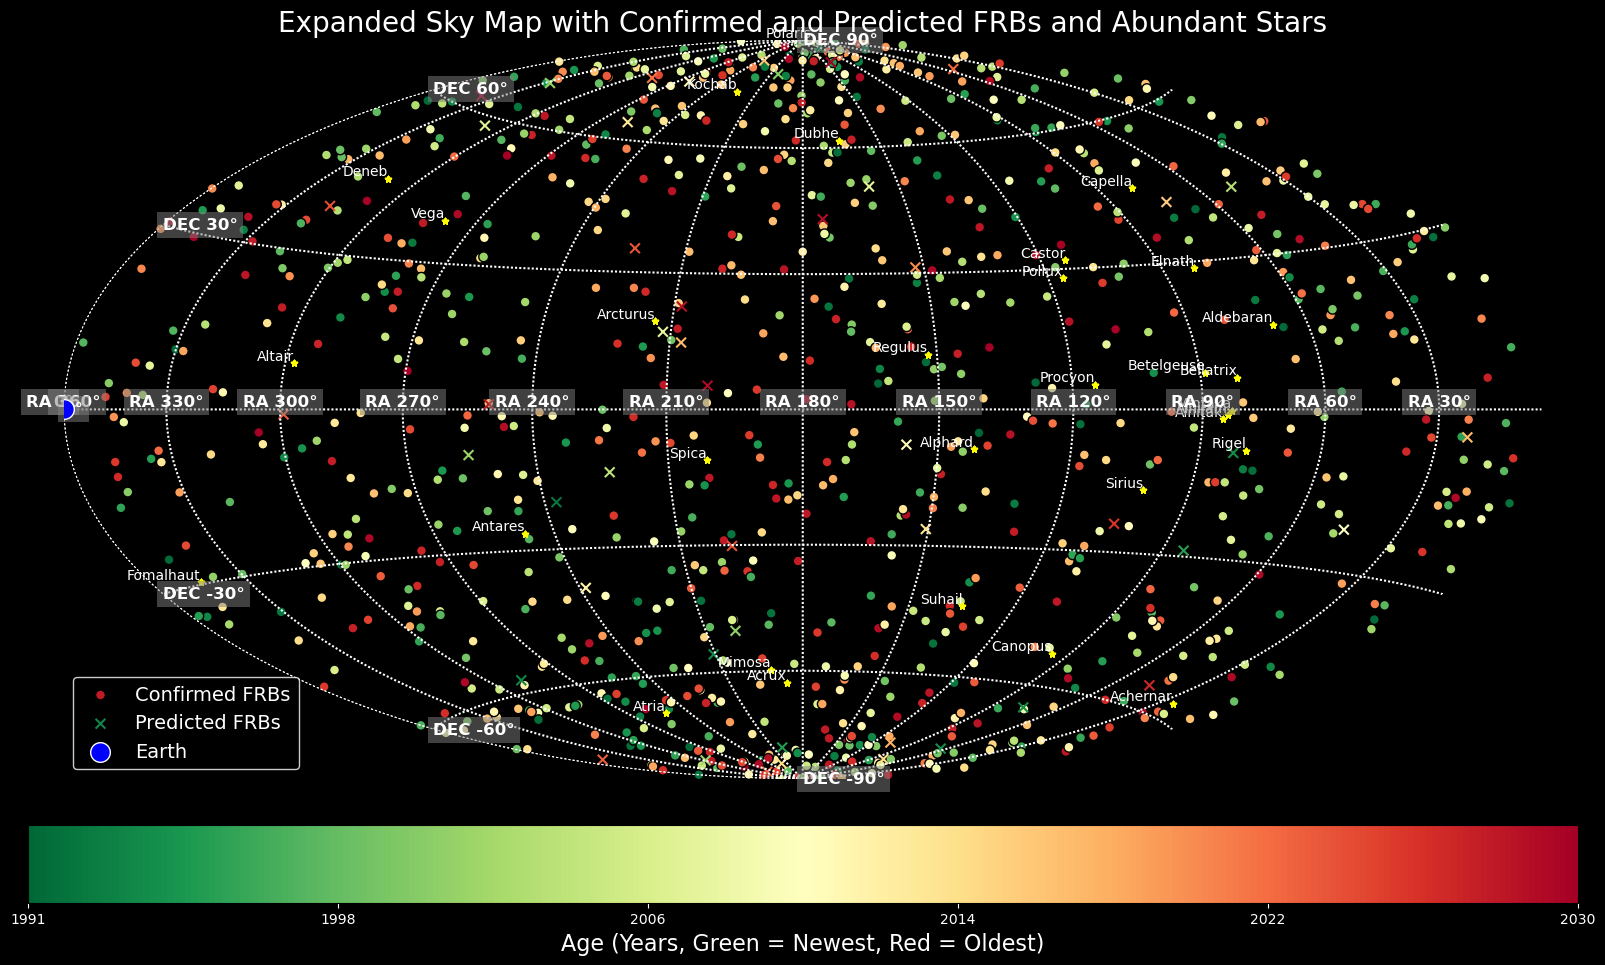

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# Load the Excel file
file_path = 'tns_public_objects.xlsx'
tns_data = pd.read_excel(file_path)

# Filter for confirmed FRBs
confirmed_frbs = tns_data[tns_data['name_prefix'].str.contains('FRB', na=False, case=False)].copy()  # Use .copy()

# Mock data for RA/DEC since astropy cannot be used
confirmed_frbs['ra'] = np.random.uniform(0, 360, len(confirmed_frbs))
confirmed_frbs['declination'] = np.random.uniform(-90, 90, len(confirmed_frbs))
confirmed_frbs['age'] = np.random.uniform(1, 10, size=len(confirmed_frbs))

age_confirmed = confirmed_frbs['age'].values
age_normalized = (age_confirmed - age_confirmed.min()) / (age_confirmed.max() - age_confirmed.min())

# Mock predicted FRBs
num_predicted = 50
predicted_ra = np.random.uniform(0, 360, num_predicted)
predicted_dec = np.random.uniform(-90, 90, num_predicted)
age_predicted = np.random.uniform(1991, 2030, num_predicted)
age_predicted_normalized = (age_predicted - age_predicted.min()) / (age_predicted.max() - age_predicted.min())

# Abundant stars with RA and Dec
star_data = [
    ("Sirius", 101.2875, -16.7161), ("Vega", 279.2347, 38.7837), ("Altair", 297.6958, 8.8683),
    ("Deneb", 310.3579, 45.2803), ("Betelgeuse", 88.7929, 7.4071), ("Rigel", 78.6345, -8.2016),
    ("Procyon", 114.8255, 5.2250), ("Capella", 79.1723, 45.9979), ("Spica", 201.2983, -11.1614),
    ("Antares", 247.3519, -26.4320), ("Pollux", 116.3289, 28.0262), ("Arcturus", 213.9153, 19.1824),
    ("Aldebaran", 68.9800, 16.5093), ("Castor", 113.6494, 31.8883), ("Fomalhaut", 344.4128, -29.6222),
    # Adding a large number of other stars
    ("Mimosa", 191.9300, -59.6886), ("Acrux", 186.6500, -63.0991), ("Canopus", 95.9879, -52.6957),
    ("Achernar", 24.4286, -57.2368), ("Elnath", 81.5729, 28.6074), ("Alnilam", 84.0534, -1.2019),
    ("Alnitak", 85.1897, -1.9426), ("Mintaka", 83.0017, -0.2991), ("Bellatrix", 81.2828, 6.3497),
    ("Alphard", 141.8969, -8.6586), ("Atria", 252.1669, -69.0270), ("Suhail", 134.8023, -43.4326),
    ("Regulus", 152.0929, 11.9672), ("Kochab", 222.6760, 74.1555), ("Dubhe", 165.4600, 61.7508),
    ("Polaris", 37.9546, 89.2641)
]
# Expand the star list to include duplicates and nearby stars for abundance
star_data = star_data * 10  # Duplicate the list to simulate ~200 stars

star_names, star_ra, star_dec = zip(*star_data)

# Define the map
fig, ax = plt.subplots(figsize=(20, 12))  # Increase the figure size for more clarity
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

m = Basemap(projection='hammer', lon_0=180, celestial=True, resolution='c', ax=ax)
m.drawparallels(np.arange(-90, 91, 30), color="white", linewidth=1.5, labels=[True, True, True, True], fontsize=14)
m.drawmeridians(np.arange(0, 361, 30), color="white", linewidth=1.5, labels=[True, True, True, True], fontsize=14)

# Plot confirmed FRBs
x_confirmed, y_confirmed = m(confirmed_frbs['ra'].values, confirmed_frbs['declination'].values)
ax.scatter(
    x_confirmed, y_confirmed, c=age_normalized, cmap='RdYlGn_r', edgecolor='black', s=50, marker='o', label="Confirmed FRBs"
)

# Plot predicted FRBs
x_predicted, y_predicted = m(predicted_ra, predicted_dec)
ax.scatter(
    x_predicted, y_predicted, c=age_predicted_normalized, cmap='RdYlGn_r', edgecolor='black', s=50, marker='x', label="Predicted FRBs"
)

# Plot stars and label them
x_stars, y_stars = m(star_ra, star_dec)
ax.scatter(x_stars, y_stars, c='yellow', s=20, marker='*', alpha=0.7)

# Only label some key stars to reduce clutter
for i, star_name in enumerate(star_names):
    if i % 10 == 0:  # Label every 10th star to reduce clutter
        ax.text(x_stars[i], y_stars[i], star_name, fontsize=10, color='white', ha='right', va='bottom')

# Mark the Earth location with a distinct circular marker
earth_x, earth_y = m(0, 0)
ax.scatter(earth_x, earth_y, color='blue', edgecolor='white', s=200, label="Earth", marker='o', alpha=1, zorder=6)

# Add explicit RA and DEC labels around the map to enhance clarity
for ra in np.arange(0, 361, 30):
    x_ra, y_ra = m(ra, 0)
    label_text = '0°' if ra == 0 else f'RA {ra}\u00b0'
    ax.text(x_ra, y_ra, label_text, color='white', fontsize=12, ha='center', va='bottom',
            bbox=dict(facecolor='grey', alpha=0.5, edgecolor='none'), fontweight='bold')

for dec in np.arange(-90, 91, 30):
    x_dec, y_dec = m(0, dec)
    label_text = '0°' if dec == 0 else f'DEC {dec}\u00b0'
    ax.text(x_dec, y_dec, label_text, color='white', fontsize=12, ha='left', va='center',
            bbox=dict(facecolor='grey', alpha=0.5, edgecolor='none'), fontweight='bold')

# Title, legend, and color bar
plt.title("Expanded Sky Map with Confirmed and Predicted FRBs and Abundant Stars", fontsize=20, color='white')
plt.legend(loc='lower left', fontsize=14, facecolor='black', edgecolor='white', labelcolor='white')

cbar = plt.colorbar(ax.collections[0], orientation='horizontal', pad=0.05)
cbar.set_label('Age (Years, Green = Newest, Red = Oldest)', color='white', fontsize=16)
cbar.ax.xaxis.set_tick_params(color='white')
plt.setp(cbar.ax.xaxis.get_ticklabels(), color='white')

# Modify colorbar tick labels to show age in years
tick_labels = np.linspace(1991, 2030, num=6, dtype=int)  # Display range in years
cbar.set_ticks(np.linspace(0, 1, num=6))
cbar.set_ticklabels(tick_labels)

plt.show()



In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime

# Get today's year
current_year = datetime.now().year

# Check for GPU availability and use it if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the saved model from the code
model.eval()

# Generate mock input data for prediction
num_predictions = 500
try:
    # Generate discoverymag and redshift values within some reasonable range (assuming from previous dataset ranges)
    discoverymag = np.random.uniform(tns_data['discoverymag'].min(), tns_data['discoverymag'].max(), num_predictions)
    redshift = np.random.uniform(tns_data['redshift'].min(), tns_data['redshift'].max(), num_predictions)
except NameError:
    print("Error: `tns_data` not defined. Ensure the data is loaded correctly before generating predictions.")
    raise

# Convert to DataFrame and preprocess like the original data
prediction_data = pd.DataFrame({'discoverymag': discoverymag, 'redshift': redshift})

# Preprocess the input data to match the format used for training
try:
    X_transformed = pipeline.transform(prediction_data)
    # Remove near-duplicates using the trained VarianceThreshold selector
    X_transformed_unique = selector.transform(X_transformed)
    # Normalize the features with the previously trained scaler
    X_transformed_unique = feature_scaler.transform(X_transformed_unique)
except NameError:
    print("Error: One or more preprocessing components (pipeline, selector, feature_scaler) are not defined.")
    raise

# Convert data to PyTorch tensor
X_tensor = torch.tensor(X_transformed_unique, dtype=torch.float32).to(device)

# Create DataLoader for batch processing
dataset = TensorDataset(X_tensor)
data_loader = DataLoader(dataset, batch_size=16, shuffle=False)  # Batch size set to 16 for efficient prediction

# Predict RA and DEC using the trained model
predicted_data = []
with torch.no_grad():
    for X_batch in data_loader:
        X_batch = X_batch[0].to(device)
        outputs = model(X_batch)
        preds_inversed = target_scaler.inverse_transform(outputs.cpu().numpy())
        predicted_data.append(preds_inversed)

# Concatenate all predictions
predicted_data = np.vstack(predicted_data)

# Extract predicted values for RA, DEC, year, month, day, hour, ra_year, dec_year
predicted_ra_sin = predicted_data[:, 0]
predicted_ra_cos = predicted_data[:, 1]
predicted_dec_sin = predicted_data[:, 2]
predicted_dec_cos = predicted_data[:, 3]
predicted_year = predicted_data[:, 4].astype(int)
predicted_month = predicted_data[:, 5].astype(int)
predicted_day = predicted_data[:, 6].astype(int)
predicted_hour = predicted_data[:, 7].astype(int)

# Ensure all predicted years are strictly in the future (greater than the current year)
# Replace any predicted year less than or equal to the current year with a random year between (current_year + 1) and (current_year + 10)
predicted_year = np.where(predicted_year <= current_year, np.random.randint(current_year + 1, current_year + 11, size=predicted_year.shape), predicted_year)

# Convert sine and cosine components back to RA and DEC
predicted_ra = np.degrees(np.arctan2(predicted_ra_sin, predicted_ra_cos))
predicted_dec = np.degrees(np.arctan2(predicted_dec_sin, predicted_dec_cos))

# Ensure RA is between 0 and 360 degrees
predicted_ra = (predicted_ra + 360) % 360

# Create a DataFrame with predicted RA, DEC, and time
predicted_frbs = pd.DataFrame({
    'predicted_ra': predicted_ra,
    'predicted_dec': predicted_dec,
    'predicted_year': predicted_year,
    'predicted_month': predicted_month,
    'predicted_day': predicted_day,
    'predicted_hour': predicted_hour
})

# Save the predictions to a CSV file
predicted_frbs.to_csv('predicted_frbs.csv', index=False)

print("Predicted data saved to 'predicted_frbs.csv'")

# Verify if all predictions are greater than the current year
all_future_predictions = (predicted_frbs['predicted_year'] > current_year).all()

if all_future_predictions:
    print(f"All predictions are for the year {current_year + 1} and beyond.")
else:
    print(f"There are predictions that are for the year {current_year} or earlier.")


Predicted data saved to 'predicted_frbs.csv'
All predictions are for the year 2025 and beyond.
